In [3]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as pkl
import pandas as pd
import os,io,sys,glob, csv, time
import matplotlib.pyplot as plt
import json
from scipy.stats import sem 
import math
from scipy.stats import pearsonr, spearmanr, zscore
import seaborn as sns

from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)

In [4]:
df_load = pd.read_json(r'C:\Users\Kim\Documents\Data\PAPERFIGURES2024\MoveMod\zeta2_final\df_zeta2.json')
df = df_load[df_load.group=='good']
df_reaches = pd.read_json(r'C:\Users\Kim\Documents\Data\final\df_reaches7.json')

In [5]:
df_run_fcn = df[df.timepoint==2][df.zeta<0.05][df.waveform_class!='axon'][df.waveform_class!='up'][df.depth>-1800]

C:\Users\Kim\AppData\Local\Temp\ipykernel_1848\642200637.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_run_fcn = df[df.timepoint==2][df.zeta<0.05][df.waveform_class!='axon'][df.waveform_class!='up'][df.depth>-1800]
C:\Users\Kim\AppData\Local\Temp\ipykernel_1848\642200637.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_run_fcn = df[df.timepoint==2][df.zeta<0.05][df.waveform_class!='axon'][df.waveform_class!='up'][df.depth>-1800]
C:\Users\Kim\AppData\Local\Temp\ipykernel_1848\642200637.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_run_fcn = df[df.timepoint==2][df.zeta<0.05][df.waveform_class!='axon'][df.waveform_class!='up'][df.depth>-1800]
C:\Users\Kim\AppData\Local\Temp\ipykernel_1848\642200637.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_run_fcn = df[df.timepoint==2][df.zeta<0.05][df.waveform_class!='axon'][df.waveform_class

In [6]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

# Parameters
pre_time = 2.0   # seconds before reach
post_time = 2.0   # seconds after reach
bin_size = 0.02  # bins

edges = np.arange(-pre_time, post_time + bin_size, bin_size)
centers = edges[:-1] + bin_size/2

peri_dict = []

for mouse_id, spikes_mouse in df_run_fcn.groupby("mouse"):
    reach_times = df_reaches.loc[df_reaches["mouse"] == mouse_id, "rMax_t"].values
    
    for unit_id, spikes_unit in spikes_mouse.groupby("cell"):
        spike_times = spikes_unit["times"].values
        wf_class = spikes_unit["waveform_class"].iloc[0]
        cohort = spikes_unit["cohort"].iloc[0] 
        depth = spikes_unit["depth"].iloc[0]
        
        all_reaches = []
        kept_reaches = 0
        
        for r in reach_times:
            # Align spikes to reach onset
            rel_spikes = spike_times[0] - r
            mask = (rel_spikes >= -pre_time) & (rel_spikes <= post_time)
            
            if np.sum(mask) == 0:
                # skip this reach if unit had no spikes
                continue
            
            counts, _ = np.histogram(rel_spikes[mask], bins=edges)
            all_reaches.append(counts)
            kept_reaches += 1
        
        if kept_reaches == 0:
            continue  # skip unit entirely if no usable reaches
        
        all_reaches = np.array(all_reaches)  # shape (n_reaches, n_bins)
        
        # Average across included reaches
        spikesperbin = all_reaches.mean(axis=0) 
        mean_fr = all_reaches.mean(axis=0) / bin_size  # Hz
        mean_fr_z = zscore(mean_fr)
        
        peri_dict.append({
            "mouse": mouse_id,
            "unit": unit_id,
            "waveform_class": wf_class,
            "depth": depth,
            "cohort": cohort,
            "time_bins": centers,
            "spikesperbin": spikesperbin,
            "fr": mean_fr,
            "fr_z": mean_fr_z,
            "n_kept_reaches": kept_reaches,
            "n_total_reaches": len(reach_times)
        })

df_peri = pd.DataFrame(peri_dict)

In [7]:
mn_fr = []
for frs in df_peri.fr:
    mn_fr.append(np.mean(frs))
df_peri['mn_fr'] = mn_fr

In [9]:
def identify_iqr_outliers(series):
# identifies iqr outliers, used for firing rates typically
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    return (series < Q1 - 1.5 * IQR) | (series > Q3 + 1.5 * IQR)
    
df_peri['log10FR'] = np.log10(df_peri.mn_fr)
df_ = df_peri
df_cup = df_[df_.cohort=='CUP']
df_cntrl = df_[df_.cohort=='cntrl']
df_cup['overallRate_iqr_outlier'] = identify_iqr_outliers(df_cup['log10FR'])
df_cntrl['overallRate_iqr_outlier'] = identify_iqr_outliers(df_cntrl['log10FR'])
df_new = pd.concat([df_cup,df_cntrl],ignore_index=True)
df_outliers_removed = df_new[df_new.overallRate_iqr_outlier!=True]

C:\Users\Kim\AppData\Local\Temp\ipykernel_1848\1776596248.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cup['overallRate_iqr_outlier'] = identify_iqr_outliers(df_cup['log10FR'])
C:\Users\Kim\AppData\Local\Temp\ipykernel_1848\1776596248.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cntrl['overallRate_iqr_outlier'] = identify_iqr_outliers(df_cntrl['log10FR'])


In [12]:
df_outliers_removed = df_outliers_removed[df_outliers_removed.waveform_class=='rs']

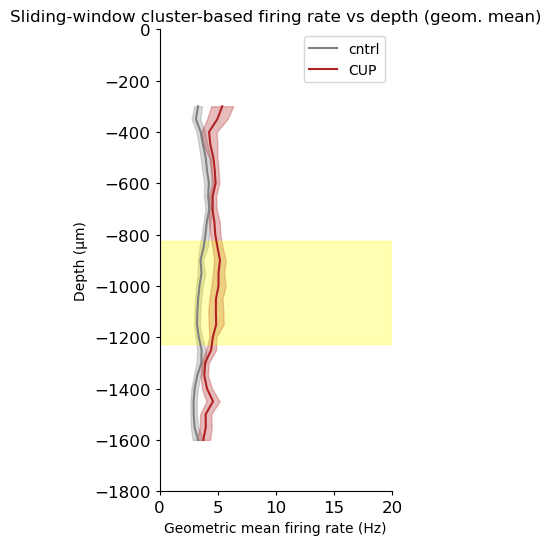

In [13]:
### same permutation test used for time

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.ticker import MultipleLocator

# --- Step 1: define sliding windows ---
window_size = 400  # µm
step_size = 50     # µm

depth_min, depth_max = df_outliers_removed['depth'].min(), df_outliers_removed['depth'].max()
window_starts = np.arange(depth_min, depth_max - window_size + step_size, step_size)
window_centers = window_starts + window_size / 2

# --- Step 2: compute per-mouse geometric means in each window ---
mice = df_outliers_removed['mouse'].unique()
cntrl_data = []
cup_data = []

for mouse in mice:
    df_mouse = df_outliers_removed[df_outliers_removed['mouse'] == mouse]
    cohort = df_mouse['cohort'].iloc[0]
    fr_windowed = []
    for start in window_starts:
        mask = (df_mouse['depth'] >= start) & (df_mouse['depth'] < start + window_size)
        fr_vals = df_mouse.loc[mask, 'mn_fr'].dropna().values
        if len(fr_vals) > 0:
            fr_gmean = stats.gmean(fr_vals)
        else:
            fr_gmean = np.nan
        fr_windowed.append(fr_gmean)
    if cohort == 'cntrl':
        cntrl_data.append(fr_windowed)
    else:
        cup_data.append(fr_windowed)

cntrl_data = np.array(cntrl_data)  # shape: n_mice x n_windows
cup_data   = np.array(cup_data)

# --- Step 3: sliding-window cluster test ---
def cluster_permutation_sliding(cntrl, cup, n_perm=1000, thresh=2.0):
    t_obs, _ = stats.ttest_ind(cntrl, cup, axis=0, equal_var=False, nan_policy='omit')
    supra_thresh = np.where(np.abs(t_obs) > thresh)[0]

    clusters = []
    cluster_masses = []
    if len(supra_thresh) > 0:
        cluster = [supra_thresh[0]]
        for idx in supra_thresh[1:]:
            if idx == cluster[-1]+1:
                cluster.append(idx)
            else:
                clusters.append(cluster)
                cluster = [idx]
        clusters.append(cluster)
        cluster_masses = [np.sum(np.abs(t_obs[c])) for c in clusters]

    # permutation null
    all_data = np.vstack([cntrl, cup])
    n_cntrl = cntrl.shape[0]
    max_cluster_masses = []
    for _ in range(n_perm):
        perm_idx = np.random.permutation(all_data.shape[0])
        perm_cntrl = all_data[perm_idx[:n_cntrl], :]
        perm_cup   = all_data[perm_idx[n_cntrl:], :]
        t_perm, _ = stats.ttest_ind(perm_cntrl, perm_cup, axis=0, equal_var=False, nan_policy='omit')
        supra = np.where(np.abs(t_perm) > thresh)[0]
        max_mass = 0
        if len(supra) > 0:
            clust = [supra[0]]
            for idx in supra[1:]:
                if idx == clust[-1]+1:
                    clust.append(idx)
                else:
                    max_mass = max(max_mass, np.sum(np.abs(t_perm[clust])))
                    clust = [idx]
            max_mass = max(max_mass, np.sum(np.abs(t_perm[clust])))
        max_cluster_masses.append(max_mass)

    cluster_pvals = [np.mean(np.array(max_cluster_masses) >= cmass) for cmass in cluster_masses]
    return clusters, cluster_pvals, t_obs



clusters, cluster_pvals, t_obs = cluster_permutation_sliding(cntrl_data, cup_data, n_perm=1000, thresh=2.0)


t_obs, p_unc = stats.ttest_ind(
    cntrl_data, cup_data, axis=0, equal_var=False, nan_policy='omit'
)

# How many mice contributed a value in each window?
n_cntrl_win = np.sum(~np.isnan(cntrl_data), axis=0)
n_cup_win   = np.sum(~np.isnan(cup_data), axis=0)

# Start with uncorrected p-values; if a window couldn't be tested, make it non-significant
p_vals_per_window = np.array(p_unc, dtype=float)
p_vals_per_window[np.isnan(p_vals_per_window)] = 1.0

# Optional: force windows with too few mice to be non-significant
min_mice_per_group = 2
too_few = (n_cntrl_win < min_mice_per_group) | (n_cup_win < min_mice_per_group)
p_vals_per_window[too_few] = 1.0

# --- Overlay cluster-corrected p-values for windows inside detected clusters ---
cluster_id_per_window = np.full(len(window_centers), -1, dtype=int)
sig_cluster_per_window = np.zeros(len(window_centers), dtype=bool)

for cid, (clust, p_cluster) in enumerate(zip(clusters, cluster_pvals)):
    clust = np.asarray(clust, dtype=int)
    cluster_id_per_window[clust] = cid
    # overwrite with cluster-level p (same p for all windows in that cluster)
    p_vals_per_window[clust] = p_cluster
    if p_cluster < 0.05:
        sig_cluster_per_window[clust] = True

df_cluster_depth = pd.DataFrame({
    "depth": window_centers,
    "p_val": p_vals_per_window,          # now never NaN (defaults to 1.0 if untestable)
    "sig_cluster": sig_cluster_per_window,
    "cluster_id": cluster_id_per_window,
    "n_cntrl": n_cntrl_win,              # super helpful to debug
    "n_cup": n_cup_win,
})

# --- Step 4: plot geometric mean ± SEM and clusters ---
fig, ax = plt.subplots(figsize=(3,6))

# Geometric mean ± SEM per cohort
for data, color, label in zip([cntrl_data, cup_data], ['gray', 'firebrick'], ['cntrl','CUP']):
    gmean_fr = np.nanmean(data, axis=0)  # mean across mice of geometric means
    sem_fr   = np.nanstd(data, axis=0) / np.sqrt(data.shape[0])
    ax.plot(gmean_fr, window_centers, color=color, label=label)
    ax.fill_betweenx(window_centers, gmean_fr - sem_fr, gmean_fr + sem_fr, color=color, alpha=0.3)

# Shade significant clusters
for clust, pval in zip(clusters, cluster_pvals):
    if pval < 0.05:
        y0 = window_centers[clust[0]] - step_size/2
        y1 = window_centers[clust[-1]] + step_size/2
        ax.axhspan(y0, y1, color='yellow', alpha=0.3)

ax.set_xlabel('Geometric mean firing rate (Hz)')
ax.set_ylabel('Depth (µm)')
ax.legend()
ax.set_title('Sliding-window cluster-based firing rate vs depth (geom. mean)')

ax.set_ylim(-1800, 0)
ax.set_xlim(0, 20)
ax.tick_params(right=False, left=True, bottom=True, top=False,
               axis='both', color='black', length=3,
               grid_color='none', labelsize=12)
ax.yaxis.set_major_locator(MultipleLocator(200))

for pos in ['right', 'top']: 
    ax.spines[pos].set_visible(False)
#fig.savefig(r'C:\Users\Kim\Documents\PAPERFIGURES\Figure4_New\25D\RS_DEPTHsliding.svg')